# Tutorial 3: Uncovering Temporal Dynamics in Neural Data

Welcome to the definitive guide on uncovering temporal relationships in your data. In neuroscience, two fundamental questions often arise:

1.  **What is the temporal offset?** Does a pattern in signal X predict a pattern in signal Y with a specific time delay (**`lag`**)?
2.  **What is the timescale of the interaction?** Over how long a period do I need to observe signal X to best predict signal Y (**`window_size`**)?

This tutorial will teach you how to answer both of these questions robustly from an agnostic perspective. We'll build a narrative from the ground up, starting with familiar concepts and progressing to the powerful, nonlinear methods that this library unlocks.

First, let's import the necessary libraries and configure our basic parameters for the MI estimation alongside of some useful plotting functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import neural_mi as nmi
from neural_mi.datasets.generators import generate_linear_data, generate_nonlinear_data, generate_history_data, generate_full_data
from neural_mi.visualize.plot import plot_cross_correlation, analyze_mi_heatmap

In [2]:
# Base parameters for our MI estimator. We'll use a simple MLP.
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 30,
    'patience': 15,
}

# Plotting function for X and Y
def plot_data(x, y, title=None, xlim=100):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x.T, label=r'$x(t)$')
    ax.plot(y.T, label=r'$y(t)$')
    ax.set_xlabel('Timepoints')
    ax.set_ylabel('Value')
    if title:
        ax.set_title(title)
    ax.set_xlim(0, xlim)
    ax.legend()
    plt.show()

## 1. The Simplest Case - Finding a Linear Lag

Let's start with a problem that many are familiar with: finding a simple, time-delayed linear relationship. We'll generate two signals, where `Y` is just a lagged and noisy version of `X`.

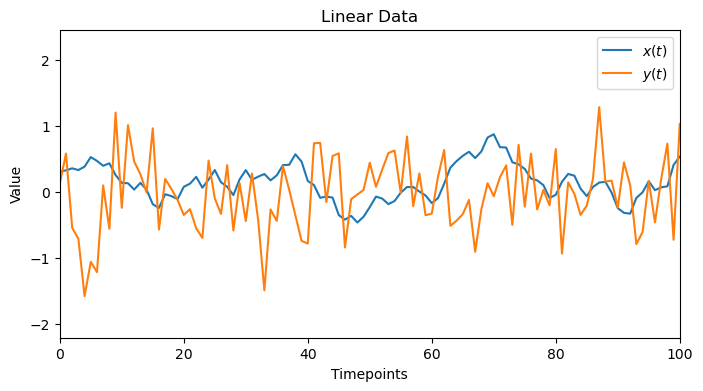

In [3]:
TRUE_LAG_LINEAR = 50
x_linear, y_linear = generate_linear_data(true_lag=TRUE_LAG_LINEAR)
plot_data(x_linear,y_linear, 'Linear Data')

### 1.1. **Linear Sanity Check: Cross-Correlation**

The classic tool for this is cross-correlation. It slides one time series past the other and calculates the linear correlation at each step. As expected, it works perfectly, showing a clear peak at the true lag.

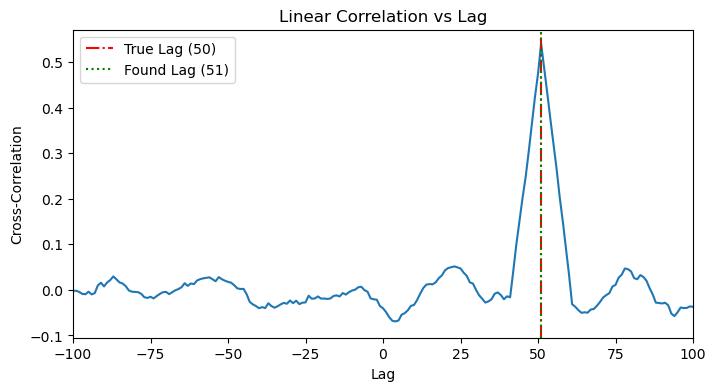

In [4]:
plot_cross_correlation(x_linear, y_linear, TRUE_LAG_LINEAR)

### 1.2. **MI Application**

Now, let's apply our MI library. Since there's no history component, `window_size` is just 1. The MI analysis also correctly identifies the lag.

2025-10-19 23:55:34 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:55:34 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:55:34 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:55:34 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-10-19 23:55:34 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/21 [00:00<?, ?task/s]

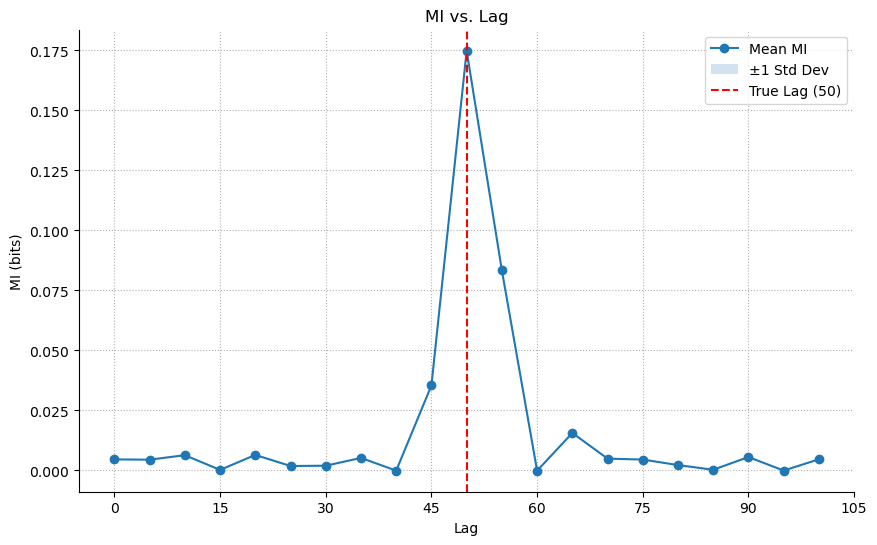

In [5]:
results_linear_lag = nmi.run(
    x_data=x_linear,
    y_data=y_linear,
    mode='lag',
    processor_type='continuous',
    processor_params={'window_size': 1},
    base_params=BASE_PARAMS,
    lag_range=range(0, 101, 5),
    n_workers=4,
)

ax = results_linear_lag.plot(show=False)
ax.axvline(TRUE_LAG_LINEAR, color='r', linestyle='--', label=f'True Lag ({TRUE_LAG_LINEAR})')
ax.legend()
plt.show()

**Lesson**: For simple linear, time-delayed relationships, both methods work. MI is a valid, more general tool.

## 2. Adding Complexity - Finding a Nonlinear Lag

Now, let's create a dataset where the relationship is **nonlinear**. For instance, `Y(t)` could be a function of `X(t - lag)^2`. This will demonstrate the limits of linear methods.

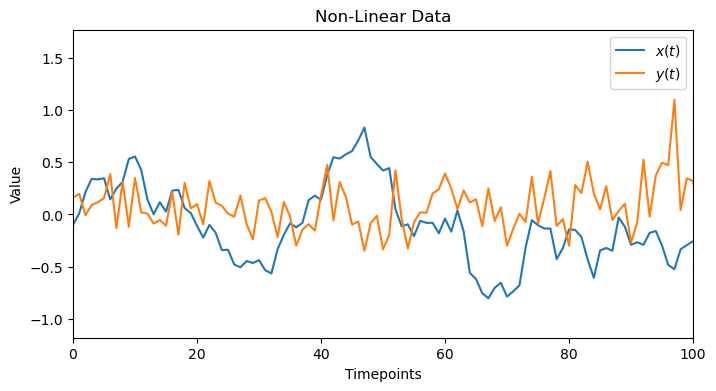

In [6]:
TRUE_LAG_NONLINEAR = 50
x_nonlinear, y_nonlinear = generate_nonlinear_data(true_lag=TRUE_LAG_NONLINEAR)
plot_data(x_nonlinear,y_nonlinear, 'Non-Linear Data')

### 2.1. **Linear Sanity Check: Failure!**

When we apply cross-correlation to this data, it fails completely. The plot shows no clear peak, as the linear method is blind to the `X^2` relationship.

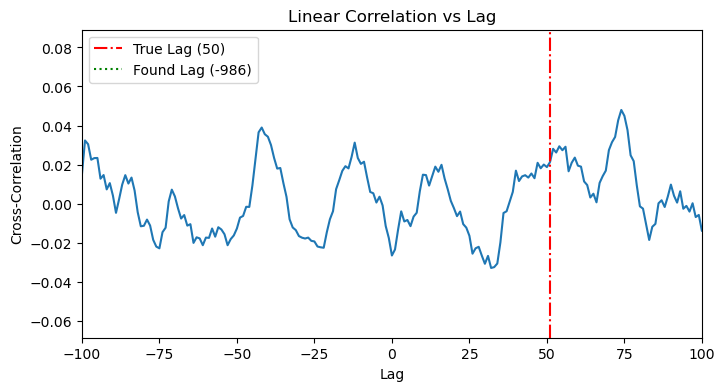

In [7]:
plot_cross_correlation(x_nonlinear, y_nonlinear, TRUE_LAG_NONLINEAR)

### 2.2. **MI Application: Success!**

Our MI tool, however, is not limited by linearity. It correctly identifies the lag by capturing the underlying statistical dependency, whatever its form.

2025-10-19 23:56:00 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:56:00 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:56:00 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:56:00 - neural_mi - INFO - Preparing 21 tasks for lag analysis.
2025-10-19 23:56:00 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/21 [00:00<?, ?task/s]

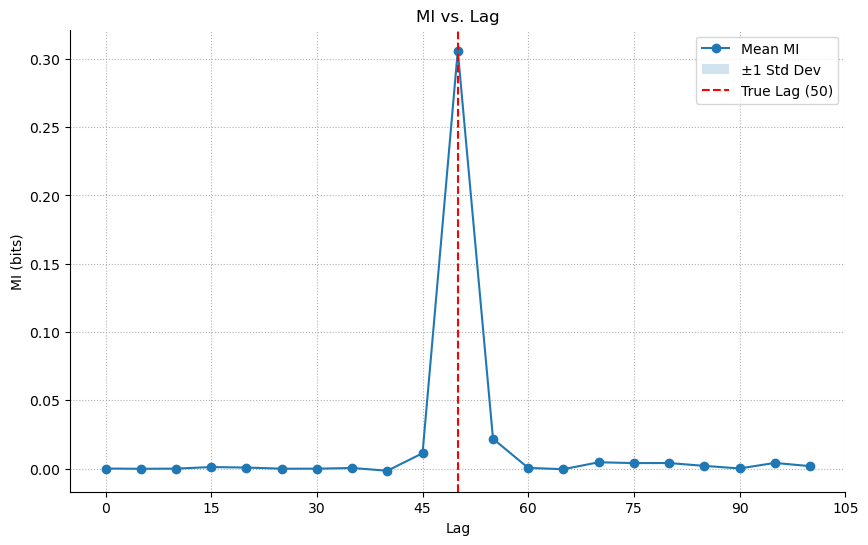

In [8]:
results_nonlinear_lag = nmi.run(
    x_data=x_nonlinear,
    y_data=y_nonlinear,
    mode='lag',
    processor_type='continuous',
    processor_params={'window_size': 1},
    base_params=BASE_PARAMS,
    lag_range=range(0, 101, 5),
    n_workers=4,
)

ax = results_nonlinear_lag.plot(show=False)
ax.axvline(TRUE_LAG_NONLINEAR, color='r', linestyle='--', label=f'True Lag ({TRUE_LAG_NONLINEAR})')
ax.legend()
plt.show()

**Lesson**: Mutual Information is essential for uncovering nonlinear relationships that linear methods miss entirely.

## 3. A New Dimension - Finding a Nonlinear History

Now we introduce the second fundamental question: "For how long?" We'll create data where `Y(t)` depends on the **history** of `X` over a recent window. To isolate this effect, we will set the true lag to zero.

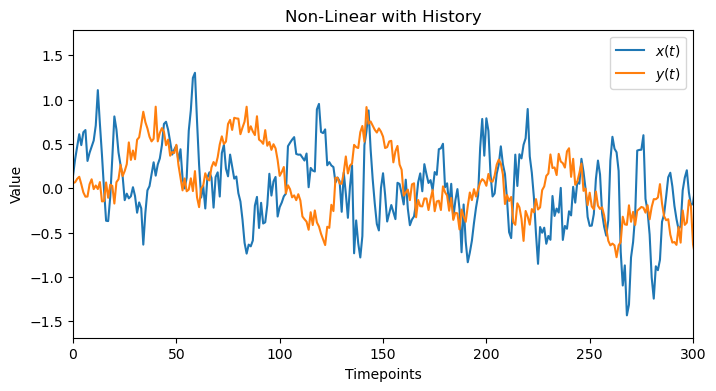

In [9]:
HISTORY_DURATION = 20
x_history, y_history = generate_history_data(history_duration=HISTORY_DURATION)
plot_data(x_history, y_history, 'Non-Linear with History', 300)

### 3.1. **Linear Check**

A linear method would fail here because of the nonlinear `tanh` function. It can show the beginning of the `history` but then saturates and decays, probably becayse of the linearity portion of `tanh`. However, this is not enough to detect the correct `window_size`.

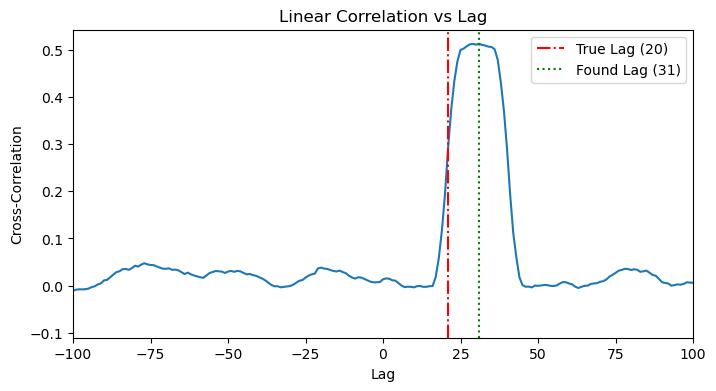

In [10]:
plot_cross_correlation(x_history, y_history, HISTORY_DURATION)

### 3.2. **MI Application: Sweeping Window Size**

We use `mode='sweep'` to test different values for `window_size`. As long as the window size is not enough to capture the history, we will get `MI~0`, once we pass the critical `window_size` that corresponds to the ture history of the data, `MI>0` and will keep increasing as bigger `window_size` can span multiple histories. The resulting plot clearly shows the MI as zero and then starting to increase right around the true `history_duration`.

In [11]:
window_sweep_grid = {'window_size': range(5, 51, 5)}

results_history = nmi.run(
    x_data=x_history,
    y_data=y_history,
    mode='sweep',
    processor_type='continuous',
    processor_params={},
    base_params=BASE_PARAMS,
    sweep_grid=window_sweep_grid,
    n_workers=4,
)

2025-10-19 23:56:27 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:56:27 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:56:27 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:56:27 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/10 [00:00<?, ?task/s]

Run b234b835-b550-4835-b045-83ca09664749_c9 | MI: 5.190:  97%|█████████▋| 29/30 [00:05<00:00,  5.18it/s] 

2025-10-19 23:56:44 - neural_mi - INFO - Parameter sweep finished.


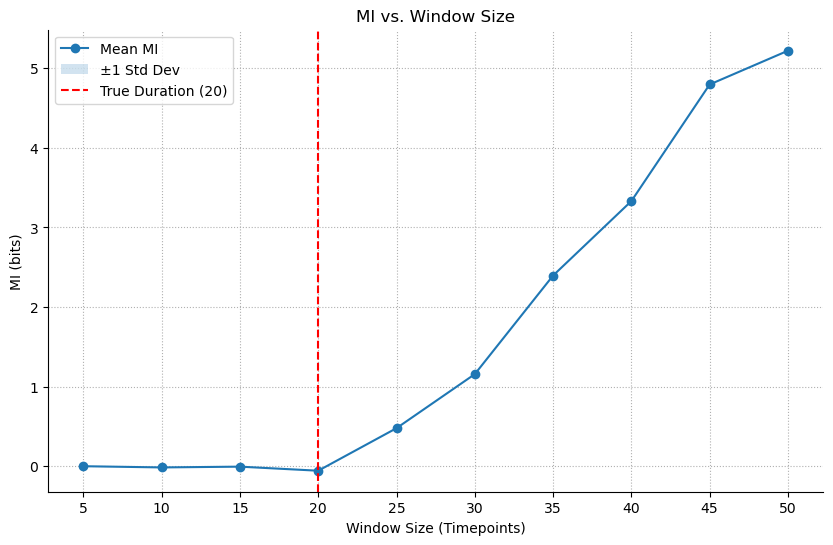

In [12]:
ax = results_history.plot(show=False)
ax.axvline(HISTORY_DURATION, color='r', linestyle='--', label=f'True Duration ({HISTORY_DURATION})')
ax.set_xlabel('Window Size (Timepoints)')
ax.legend()
plt.show()

**Lesson**: MI can determine the optimal *timescale* or *integration window* of a neural interaction, a task that has no simple linear equivalent.

## 4. The Full Picture - Agnostic Search for Lag & History

Now we combine both problems and try to solve. As we will see, when we have a combination of `lag`+`history`, we can't really disentangle them from one another --unless one of them is very large or small compared to the other one--. However, we will show how we can use our toolbox to get to the correct region and have some good herustics to infer the correct values. Our data will have both a lag and a history component from **2** and **3**.

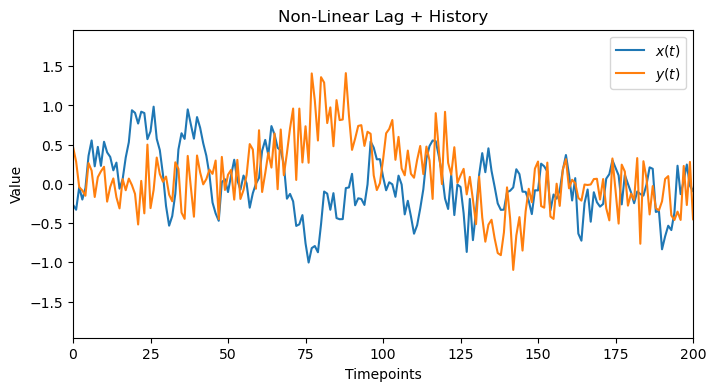

In [13]:
TRUE_LAG_FULL = 30
HISTORY_DURATION_FULL = 20
x_full, y_full = generate_full_data(true_lag=TRUE_LAG_FULL, history_duration=HISTORY_DURATION_FULL)
plot_data(x_full, y_full, 'Non-Linear Lag + History', 200)

### 4.1. **Linear Check**

Along the same lines of **3.1**, we see a more noisy cross correlation plot, where we see a peak around the *effective* time (lag+history). Again, it's not easy to detect/disentangle. We can see that the detected lag doesn't align with any of `lag` or `history`.

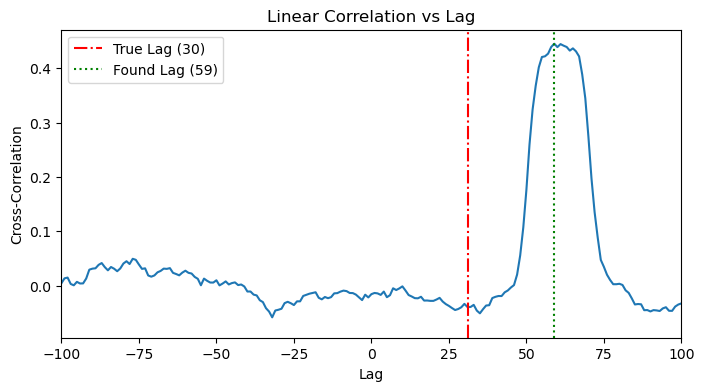

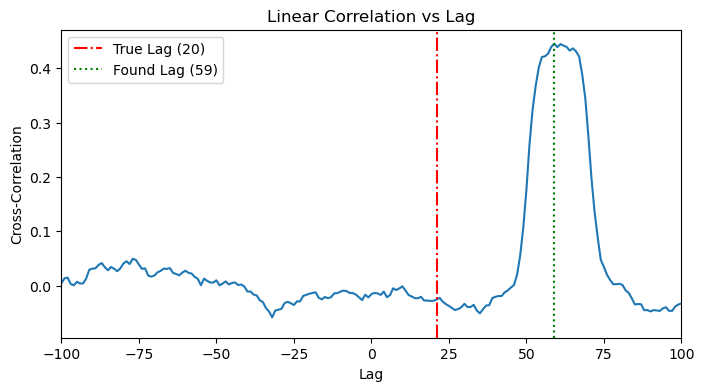

In [14]:
plot_cross_correlation(x_full, y_full, TRUE_LAG_FULL)
plot_cross_correlation(x_full, y_full, HISTORY_DURATION_FULL)

### 4.2. **MI Application: The 2D Heatmap Search**

Since we can't easily disentangle the two effects from one another, a more robust solution is to search for both parameters simultaneously. We will compute the MI over a 2D grid of possible `lag` and `window_size` values.

In [15]:
lag_range = range(0, 101, 10)
window_range = list(range(5, 101, 5))
mi_results_2d = []

print("Starting 2D sweep...")
for lag in tqdm(lag_range, desc="Lag Sweep Progress"):
    # Manually shift the data for this lag
    x_aligned, y_aligned = nmi.utils._shift_data(x_full, y_full, lag, 'continuous')
    
    # Now sweep over window sizes for this aligned data
    results = nmi.run(
        x_data=x_aligned,
        y_data=y_aligned,
        mode='sweep',
        processor_type='continuous',
        processor_params={},
        base_params=BASE_PARAMS,
        sweep_grid={'window_size': window_range},
        n_workers=8,
        verbose=False
    )
    
    # Store the results
    for _, row in results.dataframe.iterrows():
        mi_results_2d.append({'lag': lag, 'window_size': row['window_size'], 'mi': row['mi_mean']})

print("2D sweep complete!")
results_df_2d = pd.DataFrame(mi_results_2d)

Starting 2D sweep...


Lag Sweep Progress:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-19 23:56:44 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:56:44 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:56:44 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:56:44 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:57:02 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:57:02 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:57:02 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:57:02 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:57:02 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:57:21 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:57:21 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:57:21 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:57:21 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:57:21 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:57:42 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:57:42 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:57:42 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:57:42 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:57:42 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:58:07 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:58:07 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:58:07 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:58:07 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:58:07 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:58:26 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:58:26 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:58:26 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:58:26 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:58:26 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:58:47 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:58:47 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:58:47 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:58:47 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:58:47 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:59:15 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:59:15 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:59:15 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:59:15 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:59:15 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-19 23:59:40 - neural_mi - INFO - Parameter sweep finished.
2025-10-19 23:59:40 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-19 23:59:40 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-19 23:59:40 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-19 23:59:40 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-20 00:00:01 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:00:01 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-20 00:00:01 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-20 00:00:01 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-20 00:00:01 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-20 00:00:20 - neural_mi - INFO - Parameter sweep finished.
2025-10-20 00:00:20 - neural_mi - WARNING - `processor_type` is deprecated. Use `processor_type_x` and `processor_type_y` instead.
2025-10-20 00:00:20 - neural_mi - WARNING - `processor_params` is deprecated. Use `processor_params_x` and `processor_params_y` instead.
2025-10-20 00:00:20 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-20 00:00:20 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-20 00:00:39 - neural_mi - INFO - Parameter sweep finished.
2D sweep complete!


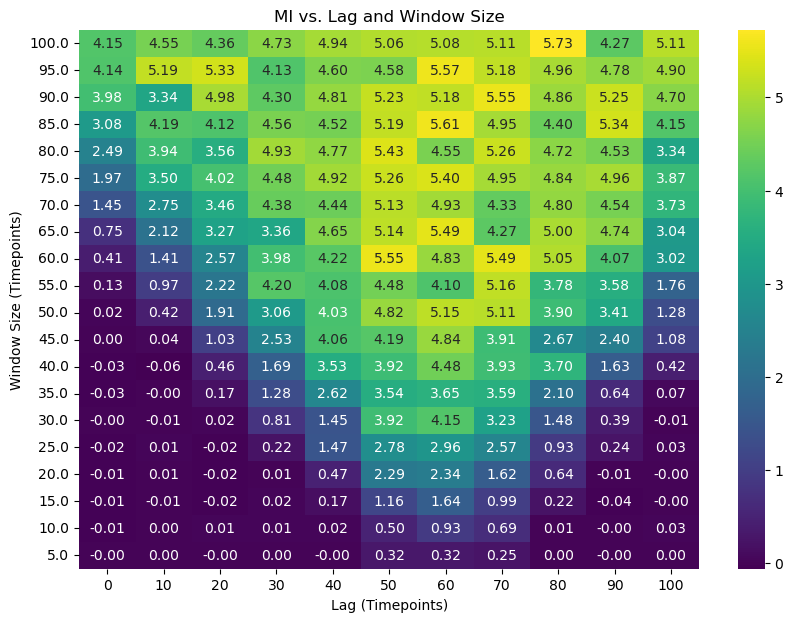

In [16]:
# Pivot the data for the heatmap
heatmap_data = results_df_2d.pivot(index='window_size', columns='lag', values='mi')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('MI vs. Lag and Window Size')
plt.xlabel('Lag (Timepoints)')
plt.ylabel('Window Size (Timepoints)')
plt.gca().invert_yaxis()
plt.show()

The heatmap we obtained is a rich tapestry of information, but just looking at it doesn't immediately tell us the answer. We will be defining and using our function, `analyze_mi_heatmap`, to perform a sophisticated topological analysis that goes far beyond simple peak-finding. But to understand why this function is necessary, we must first appreciate the hidden complexities of this map.

**The Allure of the Brightest Block (And Why It's a Trap)**
Thinking about what we can do with this heatmap, one can naively say that the brightest block with the highest MI value must be the optimal one. However, the story is a little bit more complicated than this. Remember, we are dealing with two fundamentally entangled factors: a time delay (`lag`) and an interaction duration (`history` or `window_size`).

If we only look at lags (like in a simple cross-correlation), we will miss the contribution from the window size, resulting in a blurry, smeared-out peak. If we only look at the window size without correcting for the lag, we won't have the data perfectly aligned, and we might see no information at all.

This entanglement means a simple 1D slice through our 2D map is like looking at a shadow of a 3D object—you get a distorted, incomplete picture. The brightest point on the map is just the highest peak of a complex mountain range; to truly understand the terrain, we need to understand its geography.

**The First Clue: Finding the "Boundary of Possibility"**
So, if we can't trust simple sweeps, what can we trust? Let's try a clever experiment. What if we fix our `lag` at zero and sweep the `window_size`? We are essentially asking: "With no delay, how wide must my observation window be before I start seeing any information at all?"

In our generated data, the true delay is `30` timesteps and the history is `20` timesteps. This means the complete "information window" starts `50` timesteps in the past (`30 + 20`).

When we run our `lag=0` experiment, we find that the Mutual Information stays at zero until our `window_size` becomes large enough to stretch all the way back and touch this information window. This happens precisely when `window_size = 50`, sometimes with a wiggle room that extends to `window_size ~ 55~65`.

This gives us our first profound insight: we've discovered a hard physical constraint, the **Causal Contour**. It's a line on our map defined by the equation:

`lag + window_size ≈ C`

Where `C` is the value we found (in our case, `C ≈ 50`). All of the true, meaningful interactions must happen on or above this diagonal line. Anything below it is causally impossible. This is our "Boundary of Possibility."

**The Second Clue: The "Island of Actuality"**
Our next clue comes from the heatmap itself. Not all points above the Causal Contour are interesting. We can define a threshold (e.g., `MI > 0.2`) to identify the region where a statistically significant interaction is actually occurring.

This creates an "island" on our map—a region of high MI that represents the actual observed effect. We can visualize this as an irregular contour line. This is our "Island of Actuality."

**The Synthesis: The Principle of Parsimony**
Now we have two powerful pieces of information:
1. **The Causal Contour:** The earliest possible boundary for the interaction.
2. **The Significant MI Contour:** The boundary of where the interaction is actually happening.

The naive peak might be deep inside this island, for instance at `(lag=50, window=80)`. But is this the best explanation? It captures the necessary 20 timesteps of history, but it dilutes it with 60 timesteps of irrelevant data. It's an inefficient explanation.

This brings us to the **Principle of Parsimony (or Occam's Razor):** the most elegant and physically meaningful explanation is the one that is both maximally informative (inside the significant MI island) and maximally efficient (as close as possible to the **Causal Contour**).

The true answer lies at the "leading edge" of the island—the part that first rises from the ocean of noise, right at the boundary of possibility.

### 4.3 Using the Automated Topological Analysis

The function requires several parameters:
- `results_df`: Your DataFrame with 'lag', 'window_size', and 'mi' columns
- `absolute_mi_threshold`: The MI value threshold for defining the "Significant MI Contour" (default: 0.2)
- `contour_rise_fraction`: Heuristic for detecting where MI begins to rise at lag=0 (default: 0.1)
- `radius_multiplier`: Controls the size of the Parsimonious Circle (default: 1.2)
- `true_lag` (optional): If known, the ground-truth lag value to visualize
- `history_duration` (optional): If known, the ground-truth window/history duration to visualize

#### The Analysis Pipeline

The function performs three key analyses:

1. **Causal Contour Analysis**: Examines the MI values at `lag=0` to find where information first rises above the noise floor. This identifies a critical value `C`, representing the Causal Contour line defined by `lag + window = C`. This contour represents the theoretical boundary where the window becomes large enough to capture the causal relationship.

2. **Significant MI Contour**: Identifies the boundary in parameter space where MI equals your specified threshold. This contour delineates the region where the interaction produces meaningful, statistically significant mutual information.

3. **Parsimony Analysis**: Computes the shortest "bridge" connecting the Causal Contour to the Significant MI Contour. This bridge represents the minimum parameter configuration that achieves both causal sufficiency and significant information. The midpoint of this bridge is the **Parsimonious Center** - the most efficient point in parameter space that balances theoretical necessity with empirical significance.

#### Console Output

The function prints detailed diagnostics:
- The estimated value of C from the Causal Contour analysis
- The coordinates of the bridge endpoints on both contours
- The bridge length (distance between contours)
- The Parsimonious Center coordinates (lag, window)
- The Parsimonious Circle radius
- If provided, the true parameter values for comparison

#### The Resulting Visualization

The plot provides a rich, multi-layered view of the parameter space:

- **The Viridis Heatmap**: Shows the complete information landscape across all tested lag and window combinations. Brighter colors indicate higher mutual information.

- **The Red Contour Line**: Traces the boundary of the "Significant MI Contour" where MI equals your threshold. Everything inside this contour represents parameter configurations that achieve your desired level of information capture.

- **The Cyan Dashed Line**: The "Causal Contour" showing where `lag + window = C`. This line represents the theoretical minimum window size needed to capture the causal relationship at each lag. Points below this line are theoretically insufficient; points above may be redundant.

- **The Orange Bridge Line**: Visualizes the shortest connection between the two contours. This is the path of maximum parsimony - the most direct route from theoretical sufficiency to practical significance.

- **The White Dotted Circle**: The "Parsimonious Region" centered at the bridge's midpoint. This circle highlights the optimal neighborhood in parameter space. The radius is controlled by `radius_multiplier`: at 1.0, the circle exactly touches both contours; at 1.2, it extends 20% beyond to show surrounding context.

- **The White '+' Marker**: Marks the Parsimonious Center - your best single point estimate for optimal parameters. This point represents the sweet spot where you achieve significant MI with minimal parameter complexity.

- **The Lime Rectangle** (if true parameters provided): Shows the ground-truth parameter box, allowing you to validate whether your parsimonious estimate successfully recovered the true underlying dynamics.

--- Causal Contour Analysis ---
MI at lag=0 rises at window_size = 60.0 (implies lag_true + history_true ≈ 60.0)

--- Parsimony Analysis (Significant MI > 1) ---
Shortest bridge is between [30. 30.] on Causal Contour
and [30.         32.01088479] on Significant MI Contour.
Bridge length: 2.01
Parsimonious Center: (lag=30.0, window=31.0)
Parsimonious Radius: 10.05

--- True Parameters ---
True lag: 30, True history: 20


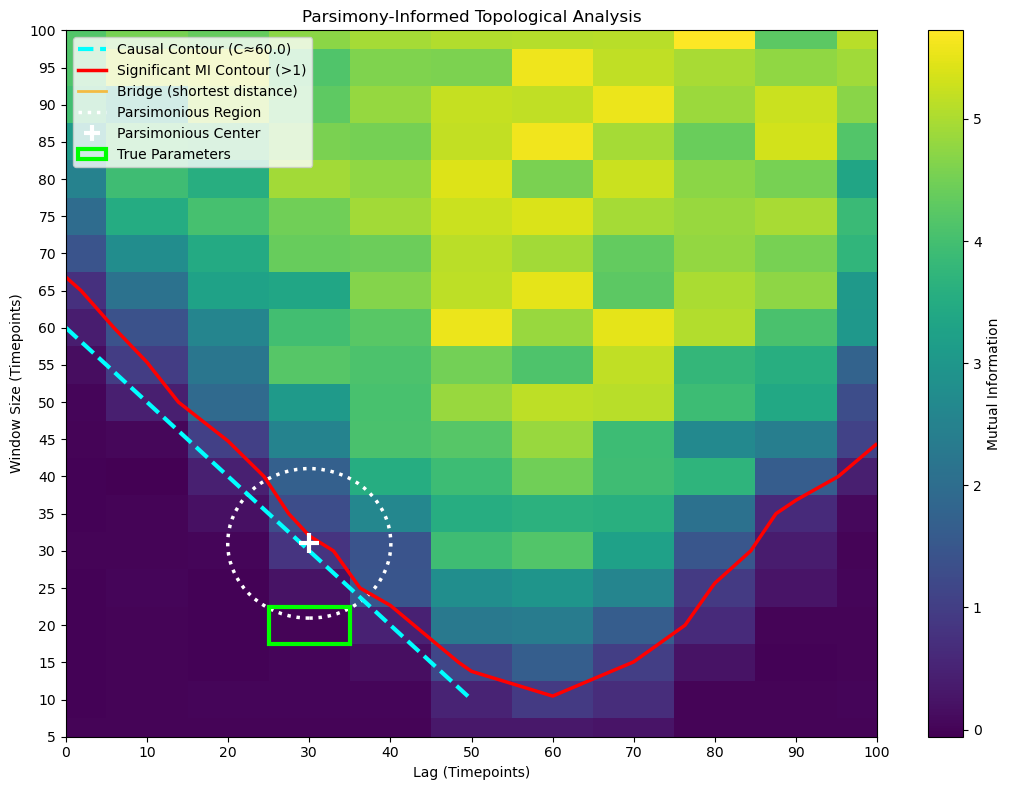

In [17]:
analyze_mi_heatmap(results_df_2d, absolute_mi_threshold=1, contour_rise_fraction=0.05, radius_multiplier=10, true_lag=TRUE_LAG_FULL, history_duration=HISTORY_DURATION_FULL)

**Lesson**: The 2D MI search is a robust and agnostic tool for characterizing the temporal dynamics between two signals.

## Conclusion: Your New Workflow

You now have a complete, principled workflow for analyzing temporal dynamics in your data:

1.  **Start Simple**: If you suspect a linear relationship, start with cross-correlation. It's fast and easy.
2.  **Go Nonlinear**: For more complex data, use the `neural_mi` library, starting with simple 1D sweeps for `lag` or `window_size` if you have a strong prior.
3.  **Perform the 2D Search**: When you need to find both the timing and the timescale of an interaction from an agnostic perspective, the 2D heatmap is the way to go.

### A Note on Model Choice

In this tutorial, we used a simple MLP model. You might have noticed that using a more complex CNN, or different critic structures, doesn't significantly change the results *for these specific examples*. This is expected.

The data we generated was based on a **moving average**, which is a smoothing operation. The key information is in the *mean value* of the window, not in any complex internal pattern. An MLP is perfectly capable of learning this simple relationship.

**When should you use a more complex model?**
- **CNN**: Choose a CNN if you hypothesize that the relationship depends on a specific *local pattern* or *shape* within the window (e.g., a spike followed by a trough).
- **RNN**: Choose a recurrent model like an LSTM or GRU if you hypothesize a dependency on the *sequential order* of events within the window.

**The takeaway is to start with the simplest model that can capture your hypothesized relationship.** For many neuroscience applications involving rate-coded or smoothed data, an MLP is a powerful and efficient choice.